In [15]:
import tensorflow as tf

# Load MNIST data
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

# Normalize and reshape the images
train_images = train_images.reshape(train_images.shape[0], -1).astype('float32') / 255

# Create a dataset for each digit
datasets = []
for digit in range(10):
    idx = train_labels == digit
    digit_images = train_images[idx]
    datasets.append(tf.data.Dataset.from_tensor_slices(digit_images).shuffle(1000).batch(1))


In [16]:
class GMMN(tf.keras.Model):
    def __init__(self):
        super(GMMN, self).__init__()
        self.dense1 = tf.keras.layers.Dense(32, activation='relu')
        self.dense4 = tf.keras.layers.Dense(784, activation='sigmoid')  # MNIST images are 28x28=784 pixels

    def call(self, inputs):
        x = self.dense1(inputs)
        # x = self.dense2(x)
        # x = self.dense3(x)
        return self.dense4(x)


In [17]:
def compute_mmd(x, y):
    """Computes the Maximum Mean Discrepancy (MMD) between two sets of samples, x and y."""
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)
    return tf.reduce_mean(x_kernel) + tf.reduce_mean(y_kernel) - 2 * tf.reduce_mean(xy_kernel)

def compute_kernel(x, y):
    """Computes a Gaussian kernel between two sets of samples."""
    x_size = tf.shape(x)[0]
    y_size = tf.shape(y)[0]
    dim = tf.shape(x)[1]
    tiled_x = tf.tile(tf.reshape(x, [x_size, 1, dim]), [1, y_size, 1])
    tiled_y = tf.tile(tf.reshape(y, [1, y_size, dim]), [x_size, 1, 1])
    return tf.exp(-tf.reduce_mean(tf.square(tiled_x - tiled_y), axis=2) / tf.cast(dim, tf.float32))


In [18]:
# Assume GMMN and compute_mmd are defined as before

models = [GMMN() for _ in range(10)]

def train_model_for_digit(digit_dataset, i):
    model = models[i]
    optimizer = tf.keras.optimizers.legacy.Adam()

    epochs = 10  # You might adjust this based on experimentation
    for epoch in range(epochs):
        for real_images in digit_dataset:
            with tf.GradientTape() as tape:
                noise = tf.random.normal([real_images.shape[0], 100])  # 100-dimensional noise vector
                generated_images = model(noise)
                mmd_loss = compute_mmd(real_images, generated_images)
            
            gradients = tape.gradient(mmd_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
        print(f'Epoch {epoch+1}, MMD Loss: {mmd_loss.numpy()}')
    return model

for i, dataset in enumerate(datasets):
    print(f"Training model for digit {i}")
    model = train_model_for_digit(dataset, i)


Training model for digit 0


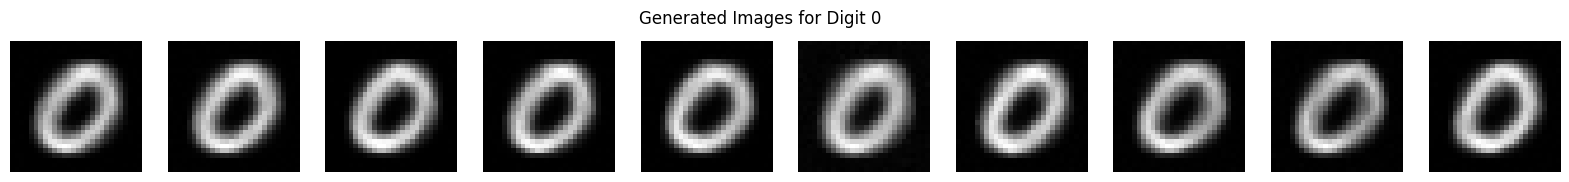

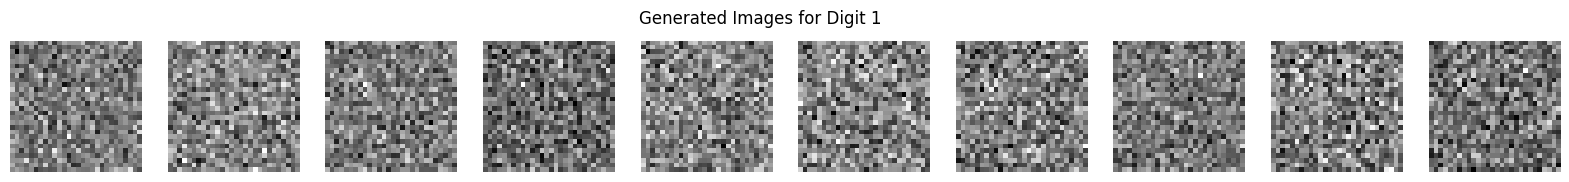

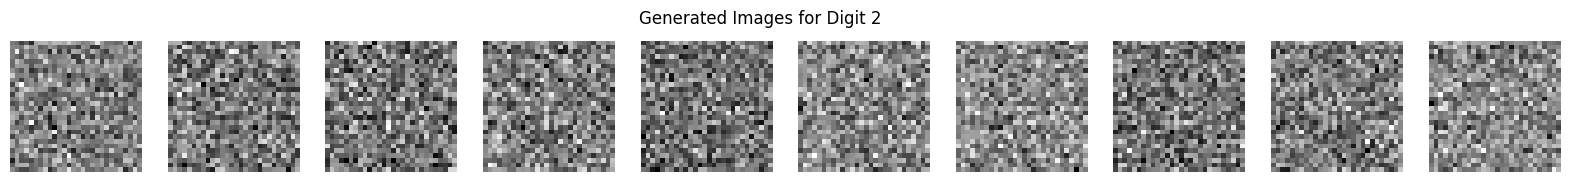

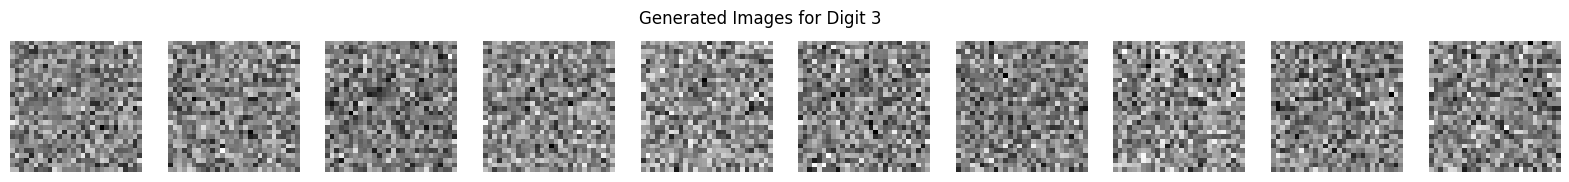

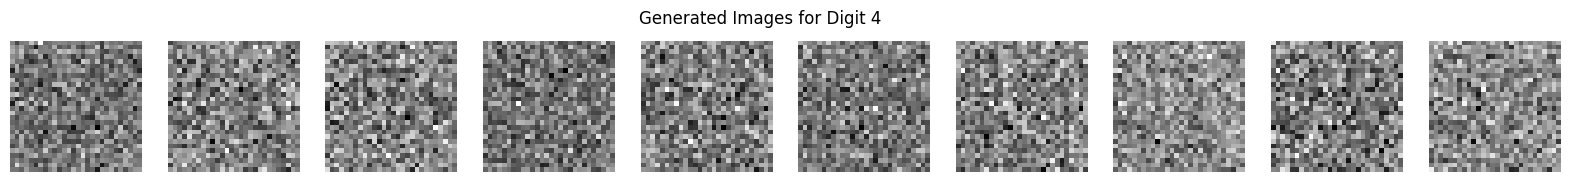

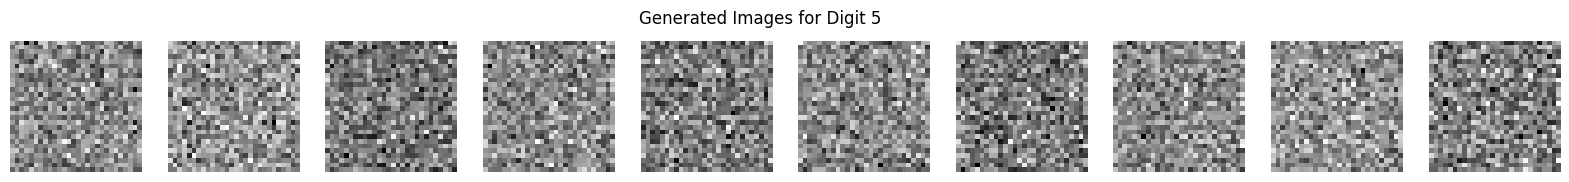

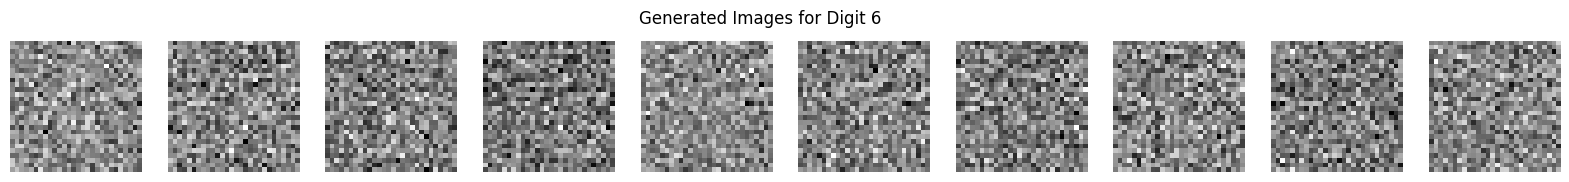

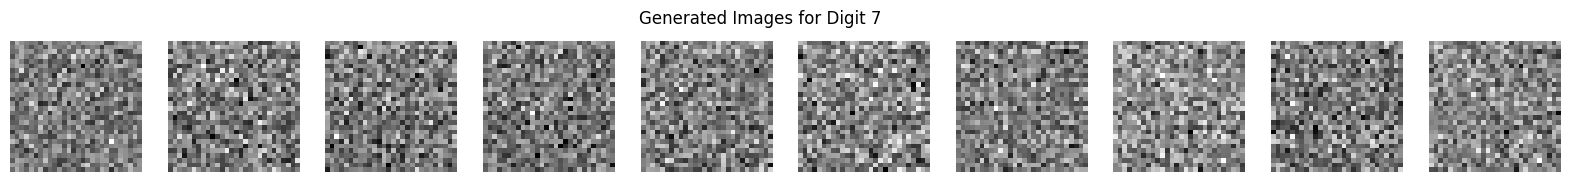

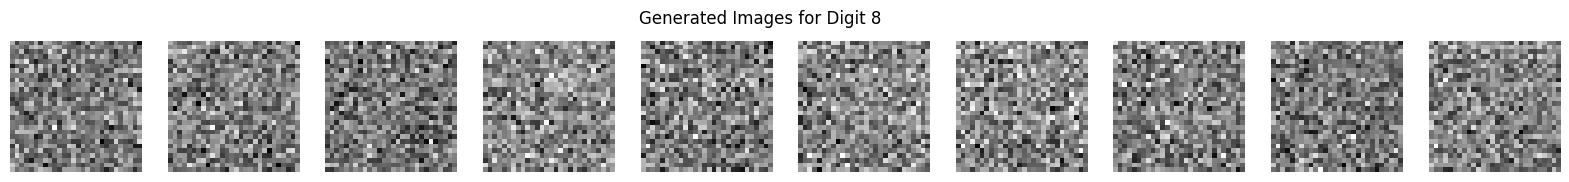

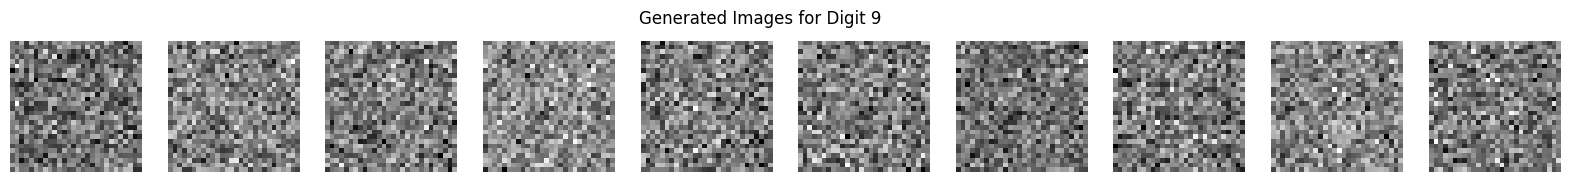

In [ ]:
import matplotlib.pyplot as plt

def generate_images(model, digit, num_images=10):
    noise = tf.random.normal([num_images, 100])
    generated_images = model(noise)
    generated_images = tf.reshape(generated_images, (-1, 28, 28))

    fig, axes = plt.subplots(1, num_images, figsize=(20, 2))
    for i, ax in enumerate(axes):
        ax.imshow(generated_images[i, :, :], cmap='gray')
        ax.axis('off')
    plt.suptitle(f'Generated Images for Digit {digit}')
    plt.show()

# Generate and display images for each digit
for i, model in enumerate(models):
    generate_images(model, digit=i)
